In [1]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

In [2]:
from targets.conditional_density_estimation_target import Wave
target = Wave()

N_simulations = 10000
D_theta = torch.linspace(-8,8,N_simulations).unsqueeze(-1)
D_x = target.simulate(D_theta)

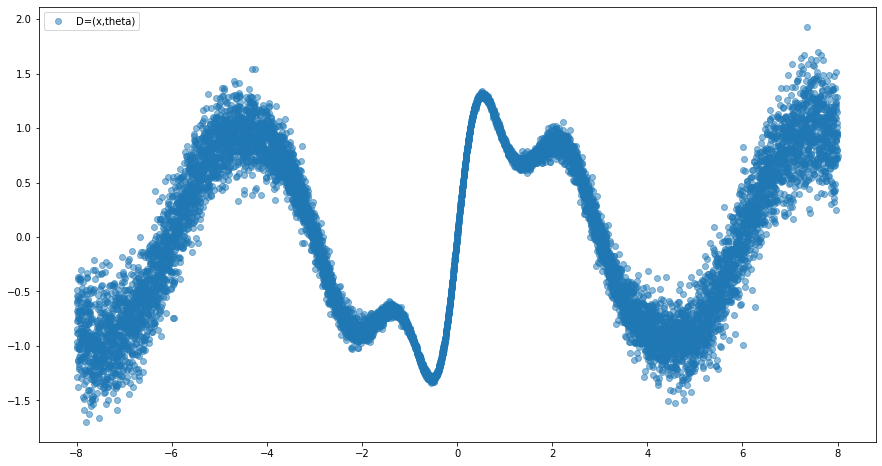

In [3]:
plt.figure(figsize = (15,8))
plt.set_xlim = (-8,8)
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
plt.legend()

In [13]:
alpha = torch.tensor(5.)
truncation = 20
Beta_distribution = torch.distributions.Beta(1, alpha)

In [14]:
def sample_weights(z): 
    counts = torch.unique(z, return_counts = True)[1]
    probs = torch.cat([counts,alpha.unsqueeze(-1)], dim = -1)
    w = torch.distributions.Dirichlet(probs).sample()
    r = w[-1]
    w_ = w[:-1]
    for i in range(truncation-1):
        v = Beta_distribution.sample()
        w = r*v
        r = r*(1-v)
        w_ = torch.cat([w_,w.unsqueeze(-1)], dim = -1)
    w_ = torch.cat([w_,r.unsqueeze(-1)], dim = -1)
    return w_

In [15]:
d=1
nu = 2
lbda = 0.01
mu = torch.zeros(d)
psi = torch.eye(d)

def sample_prior_parameters_theta(num_samples):
    sigma_theta = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(psi)).sample([num_samples]))
    sigma_theta = (sigma_theta + torch.transpose(sigma_theta, 1,2))/2
    mean_theta = torch.distributions.MultivariateNormal(mu,scale_tril = torch.cholesky(sigma_theta)/(lbda**(1/2))).sample()
    return mean_theta, sigma_theta

mu_beta = torch.zeros(d+1)
sigma_beta = torch.eye(d+1)
eta = 2
phi  = torch.eye(d)

def sample_prior_parameters_x(num_samples):
    sigma_x = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(psi)).sample([num_samples]))
    beta = torch.distributions.MultivariateNormal(mu_beta, sigma_beta).sample([num_samples])
    return beta, sigma_x
    
def repopulate_parameters(mean_theta, sigma_theta, beta, sigma_x):
    _mean_theta, _sigma_theta = sample_prior_parameters_theta(truncation)
    mean_theta = torch.cat([mean_theta, _mean_theta], dim = 0)
    sigma_theta = torch.cat([sigma_theta, _sigma_theta], dim = 0)
    _beta, _sigma_x = sample_prior_parameters_x(truncation)
    beta = torch.cat([beta, _beta], dim = 0)
    sigma_x = torch.cat([sigma_x,_sigma_x], dim=0)
    return mean_theta, sigma_theta, beta, sigma_x

In [16]:
def sample_allocation(w, D_x,D_theta,mean_theta, sigma_theta, beta, sigma_x): 
    w_i_k = w.unsqueeze(0).repeat(D_x.shape[0],1)
    p_i_k_theta = torch.exp(torch.distributions.MultivariateNormal(mean_theta, sigma_theta).log_prob(D_theta.unsqueeze(1).repeat(1,w.shape[0],1)))
    temp_mean = (torch.cat([D_theta, torch.ones(D_theta.shape[0],1)], dim =1)@beta.T).unsqueeze(-1)
    temp_sigma_x =  sigma_x.unsqueeze(0).repeat(D_x.shape[0],1,1,1)
    temp_x = D_x.unsqueeze(1).repeat(1, w.shape[0],1)
    p_i_k_x_theta = torch.exp(torch.distributions.MultivariateNormal(temp_mean,temp_sigma_x).log_prob(temp_x))
    temp = w_i_k*p_i_k_theta*p_i_k_x_theta
    return torch.distributions.Categorical(temp/ torch.sum(temp, dim = -1).unsqueeze(-1)).sample()

In [17]:
def equivalent_allocation(z,mean_theta, sigma_theta, beta, sigma_x):
    unique, inverse_index = torch.unique(z, return_inverse = True)
    new_mean_theta = mean_theta[unique]
    new_sigma_theta = sigma_theta[unique]
    new_beta = beta[unique]
    new_sigma_x = sigma_x[unique]
    return inverse_index,new_mean_theta, new_sigma_theta, new_beta, new_sigma_x

In [18]:
mu_phi = torch.zeros(d+1)
sigma_phi = torch.eye(d+1)

def sample_parameter_posterior(z,D_x, D_theta):
    list_cov_theta = []
    list_mean_theta = []
    list_beta = []
    list_cov_x = []
    for c in torch.unique(z):
        D_x_c = D_x[z==c]
        D_theta_c = D_theta[z==c]
        N_c = D_x_c.shape[0]
        
        ###Posterior on mean_theta, sigma_theta
        empirical_mean_theta = torch.mean(D_theta_c, dim =0)
        mu_c = (lbda*mu + N_c*empirical_mean_theta)/(lbda + N_c)
        S = torch.cov(D_theta_c.T)*(N_c-1) if N_c>=2 else torch.zeros(d)
        temp = (empirical_mean_theta-mu).unsqueeze(-1)
        Psi_c = psi + S + (lbda*N_c*temp@temp.T)/(lbda + N_c)
        cov_theta_c = torch.inverse(torch.distributions.Wishart(nu + N_c,torch.inverse(Psi_c)).sample())
        cov_theta_c = (cov_theta_c + torch.transpose(cov_theta_c,0,1))/2
        mean_theta_c = torch.distributions.MultivariateNormal(mu_c, scale_tril = torch.cholesky(cov_theta_c)/((lbda + N_c)**(1/2))).sample()
        list_cov_theta.append(cov_theta_c.unsqueeze(0))
        list_mean_theta.append(mean_theta_c.unsqueeze(0))
        
        empirical_mean_x = torch.mean(D_x_c, dim =0)
        S = torch.cov(D_x_c.T)*(N_c-1) if N_c>=2 else torch.zeros(d)
        temp = (empirical_mean_x-mu).unsqueeze(-1)
        Phi_c = phi + S + (lbda*N_c*temp@temp.T)/(lbda + N_c)
        cov_x_c = torch.inverse(torch.distributions.Wishart(eta + N_c,torch.inverse(Phi_c)).sample())
        list_cov_x.append(cov_x_c.unsqueeze(0))
        
        temp = torch.cat([D_theta_c, torch.ones(D_theta_c.shape[0]).unsqueeze(-1)], dim = -1)
        sigma_phi_d = torch.inverse(temp.T@temp/cov_x_c[0,0]+ torch.inverse(sigma_phi))
        mu_phi_d = sigma_phi_d@(D_x_c.squeeze(-1)@temp/cov_x_c[0,0]+ torch.inverse(sigma_phi)@mu_phi)
        sigma_phi_d = (sigma_phi_d + torch.transpose(sigma_phi_d,0,1))/2
        beta_c = torch.distributions.MultivariateNormal(mu_phi_d, scale_tril = torch.cholesky(sigma_phi_d)).sample()
        
        list_beta.append(beta_c.unsqueeze(0))
    return torch.cat(list_mean_theta, dim = 0), torch.cat(list_cov_theta, dim = 0), torch.cat(list_beta, dim =0), torch.cat(list_cov_x, dim = 0)

In [19]:
from IPython.display import clear_output
def plot_all(z,D_x, D_theta,mean_theta, sigma_theta, beta, sigma_x):
    plt.figure(figsize = (10,10))
    plt.scatter(D_theta.squeeze(-1).numpy(), D_x.squeeze(-1).numpy(), c=z, cmap = matplotlib.cm.get_cmap('plasma'), alpha = .5)
    plt.scatter(theta0, x0, color = 'green')

def joint_log_prob(z,mean_theta, sigma_theta, beta, sigma_x, X, Theta):
    unique, count = torch.unique(z, return_counts = True)
    return torch.sum((count/z.shape[0]).unsqueeze(0).unsqueeze(-1)*torch.exp(torch.distributions.MultivariateNormal(mean_theta, sigma_theta).log_prob(Theta.unsqueeze(1).repeat(1,mean_theta.shape[0],1))).T.unsqueeze(0)*torch.exp(torch.distributions.MultivariateNormal((beta@torch.cat([Theta, torch.ones(Theta.shape[0],1)], dim = 1).T).unsqueeze(-1), sigma_x.unsqueeze(1).repeat(1,Theta.shape[0],1,1)).log_prob(X.unsqueeze(1).repeat(1,mean_theta.shape[0],1).unsqueeze(2).repeat(1,1,Theta.shape[0],1))), dim = 1)


In [21]:
import warnings
warnings.filterwarnings("ignore")
z = torch.zeros(N_simulations)
mean_theta, sigma_theta = sample_prior_parameters_theta(torch.unique(z).shape[0])
beta, sigma_x = sample_prior_parameters_x(torch.unique(z).shape[0])
list_theta = []
#while True:
for i in range(100):    
    clear_output(wait = True)
    plt.figure(figsize = (15,8))
    prob = joint_log_prob(z,mean_theta, sigma_theta, beta, sigma_x, torch.linspace(-2,2,75).unsqueeze(-1), torch.linspace(-8,8,75).unsqueeze(-1))
    plt.contourf(torch.linspace(-8,8,75),torch.linspace(-2,2,75), prob, levels = 20)
    w = sample_weights(z)
    mean_theta, sigma_theta, beta, sigma_x = repopulate_parameters(mean_theta, sigma_theta, beta, sigma_x)
    z = sample_allocation(w, D_x, D_theta, mean_theta, sigma_theta, beta, sigma_x)
    z, mean_theta, sigma_theta, beta, sigma_x = equivalent_allocation(z, mean_theta, sigma_theta, beta, sigma_x)
    mean_theta, sigma_theta, beta, sigma_x = sample_parameter_posterior(z,D_x, D_theta)
    
    '''tt_theta = torch.linspace(-20,20,1000)
    input_theta = torch.cat([tt_theta.unsqueeze(-1), torch.ones(1000,1)], dim = -1)
    for b in beta:
        x_b = input_theta@b
        plt.plot(tt_theta[-2.<x_b][x_b[-2.<x_b]<2].numpy(), x_b[-2.<x_b][x_b[-2.<x_b]<2].numpy(), color = 'White', linestyle = '--')
    '''
    plt.xlim([-8, 8])
    plt.ylim([-2, 2])
    plt.show()

KeyboardInterrupt: 